<a href="https://colab.research.google.com/github/FranklinFrostt/PortfolioProjects/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# For time series modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/Superstore.csv',
    encoding='latin-1',
    delimiter=',',  # Could be ; or \t
    quotechar='"',
    engine='python'  # Fallback parser
)


In [ ]:
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

In [ ]:
# Convert date column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Order Date'].min()} to {df['Order Date'].max()}")
df.head()

# Check for missing values
df.info()
df.isnull().sum()

# Basic statistics
df.describe()

Dataset shape: (9994, 21)
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   object        
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object     

,Row ID,Order Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


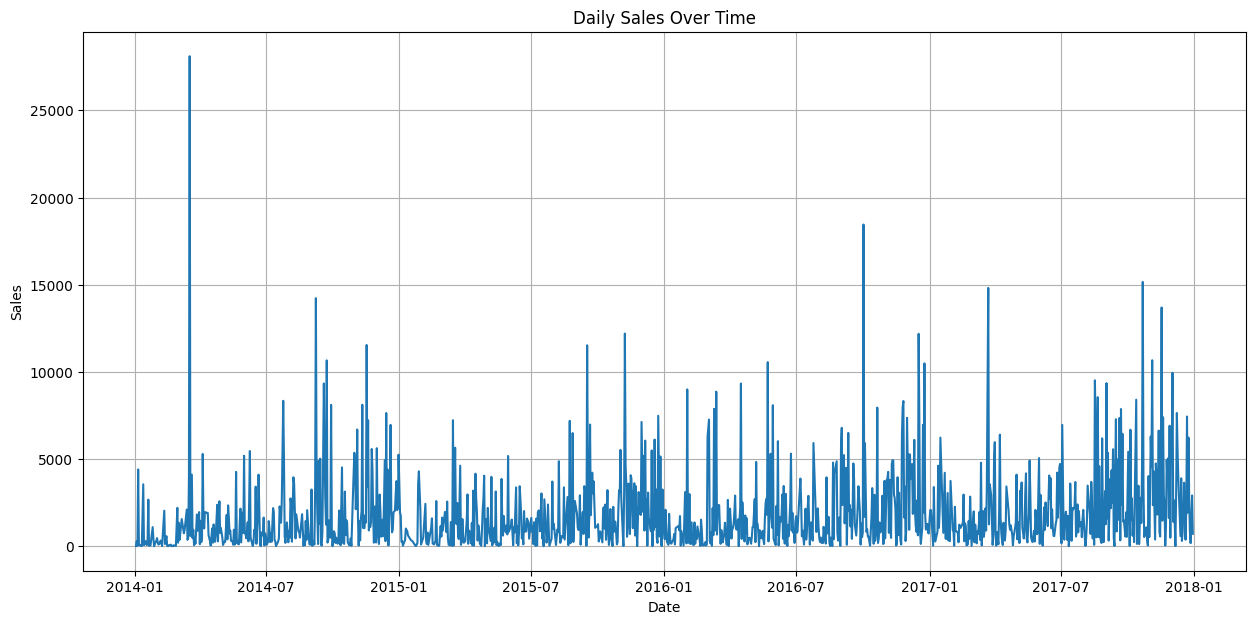

In [ ]:
# Aggregate data to daily sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Set date as index
daily_sales.set_index('Order Date', inplace=True)

# Visualize the time series
plt.figure(figsize=(15, 7))
plt.plot(daily_sales.index, daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

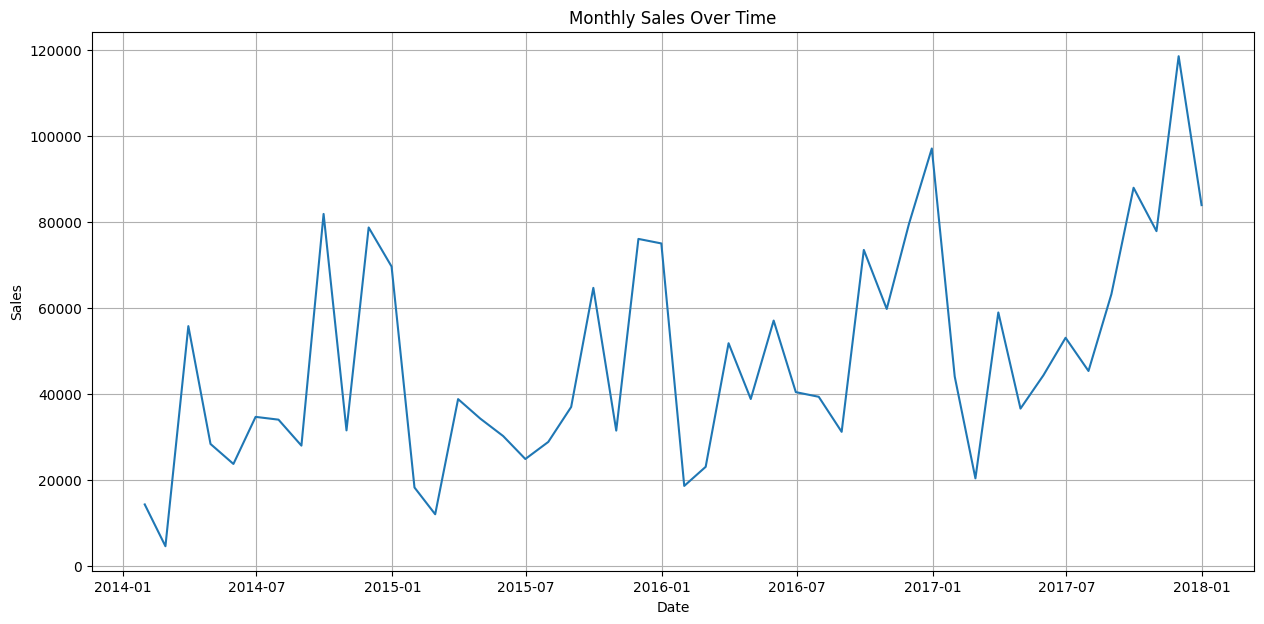

In [ ]:
# Create monthly data for easier analysis
monthly_sales = daily_sales.resample('ME').sum()

# Plot monthly sales
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales.index, monthly_sales['Sales'])
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
# Check for missing values in the time series
print(f"Number of missing values: {monthly_sales['Sales'].isnull().sum()}")

# Fill any missing values with interpolation
monthly_sales['Sales'] = monthly_sales['Sales'].interpolate()

Number of missing values: 0


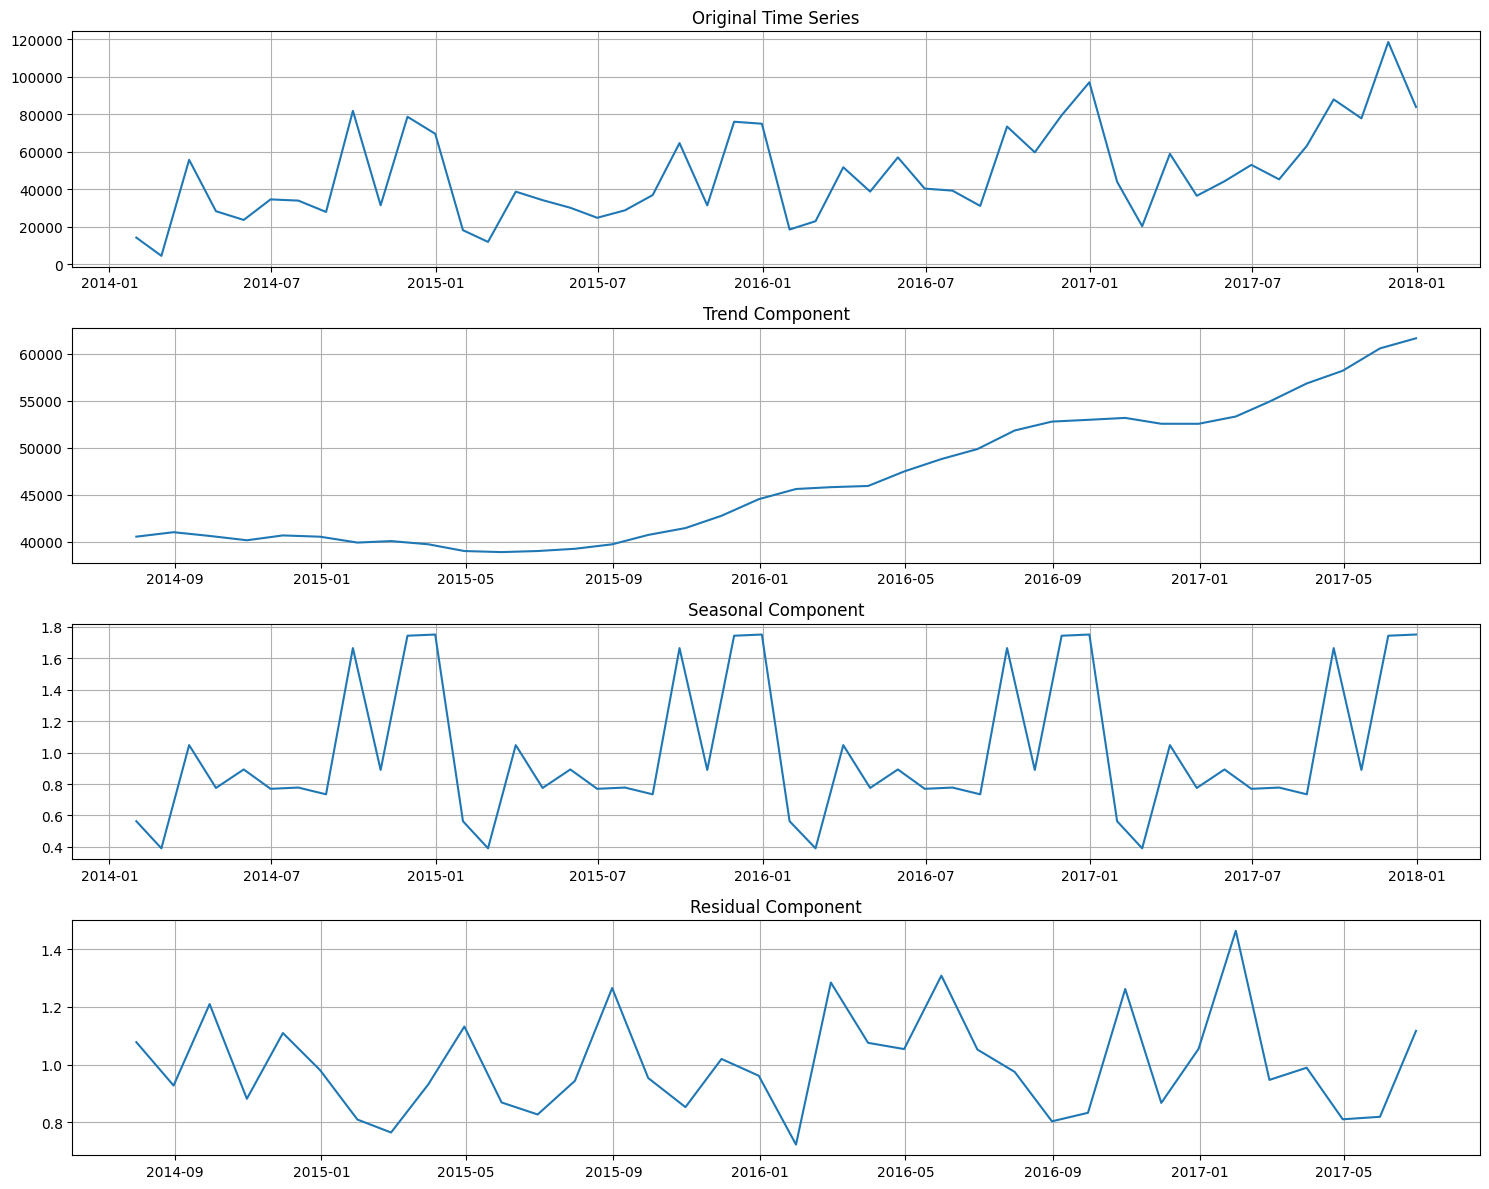

Stationarity Test on Original Series:
ADF Statistic: -4.493767844002665
p-value: 0.00020180198458237758
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064
Conclusion: The series is stationary


In [ ]:
# Seasonal decomposition
result = seasonal_decompose(monthly_sales['Sales'], model='multiplicative', period=12)

# Plot decomposition
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(monthly_sales.index, monthly_sales['Sales'])
plt.title('Original Time Series')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend Component')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.show()

# Check stationarity (Augmented Dickey-Fuller test)
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("Conclusion: The series is stationary")
    else:
        print("Conclusion: The series is non-stationary")

# Check stationarity of the original series
print("Stationarity Test on Original Series:")
check_stationarity(monthly_sales['Sales'])

# If non-stationary, difference the series
if adfuller(monthly_sales['Sales'].dropna())[1] > 0.05:
    monthly_sales['Sales_diff'] = monthly_sales['Sales'].diff().dropna()

    plt.figure(figsize=(15, 7))
    plt.plot(monthly_sales.index[1:], monthly_sales['Sales_diff'])
    plt.title('Differenced Series')
    plt.xlabel('Date')
    plt.ylabel('Sales Difference')
    plt.grid(True)
    plt.show()

    print("\nStationarity Test on Differenced Series:")
    check_stationarity(monthly_sales['Sales_diff'].dropna())

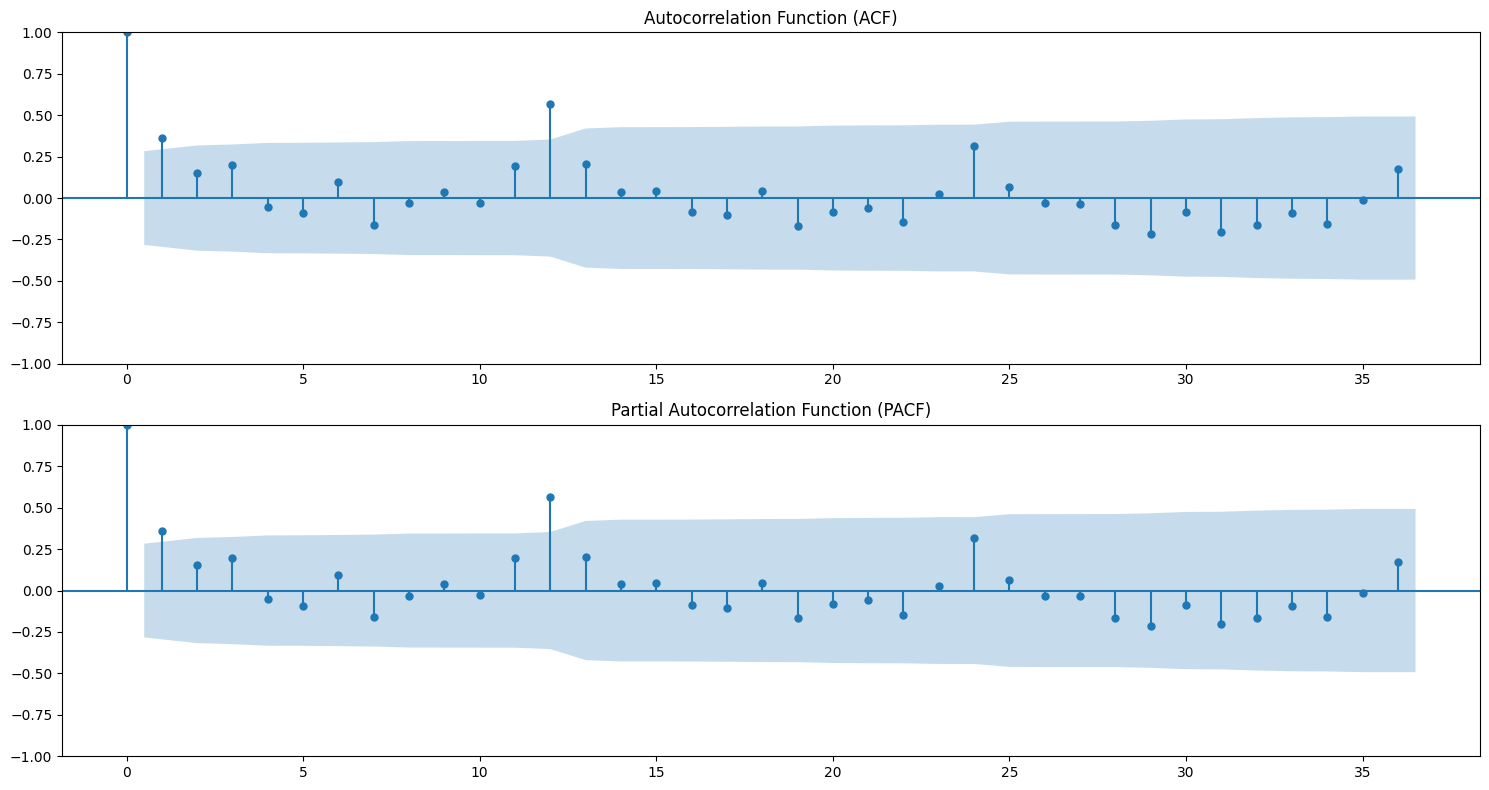

In [ ]:
# Plot ACF and PACF for parameter selection
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plot_acf(monthly_sales['Sales'].dropna(), ax=plt.gca(), lags=36)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_acf(monthly_sales['Sales'].dropna(), ax=plt.gca(), lags=36)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# For differenced series if needed
if 'Sales_diff' in monthly_sales.columns:
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plot_acf(monthly_sales['Sales_diff'].dropna(), ax=plt.gca(), lags=36)
    plt.title('ACF of Differenced Series')

    plt.subplot(2, 1, 2)
    plot_pacf(monthly_sales['Sales_diff'].dropna(), ax=plt.gca(), lags=36)
    plt.title('PACF of Differenced Series')

    plt.tight_layout()
    plt.show()

Training data: 2014-01-31 00:00:00 to 2017-02-28 00:00:00
Testing data: 2017-03-31 00:00:00 to 2017-12-31 00:00:00


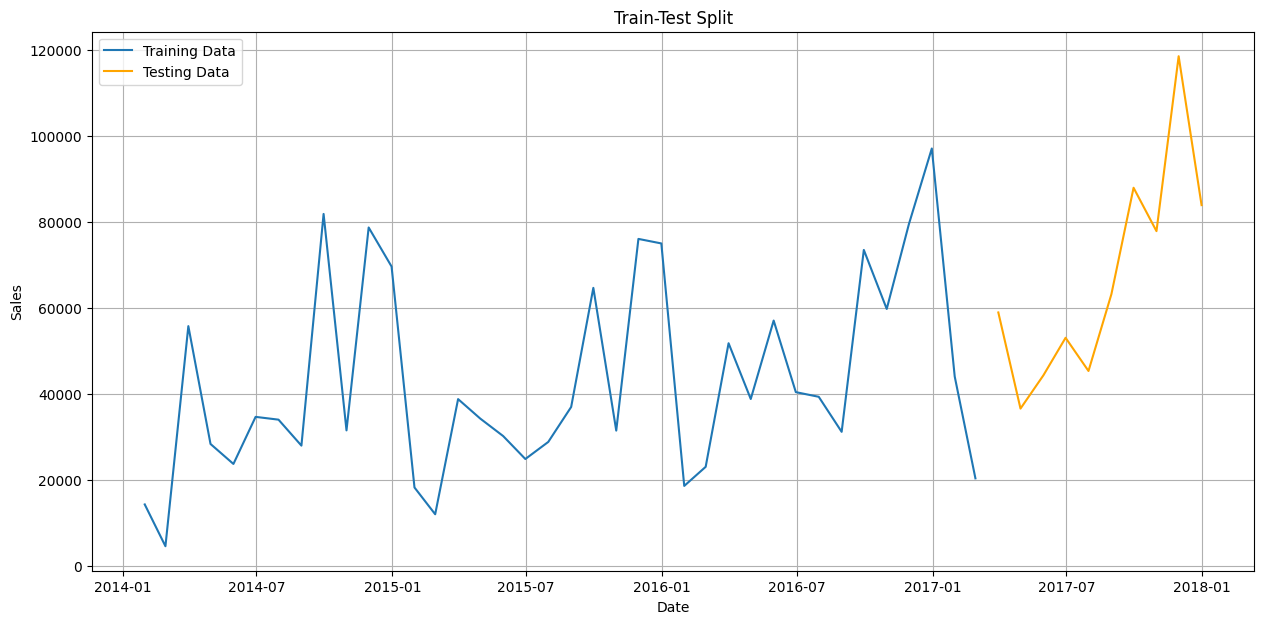

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -118.375
Date:                            Mon, 10 Mar 2025   AIC                            246.751
Time:                                    17:22:34   BIC                            248.740
Sample:                                01-31-2014   HQIC                           245.496
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2526      0.621     -0.407      0.684      -1.469       0.964
ma.L1         -0.9875      1.008   

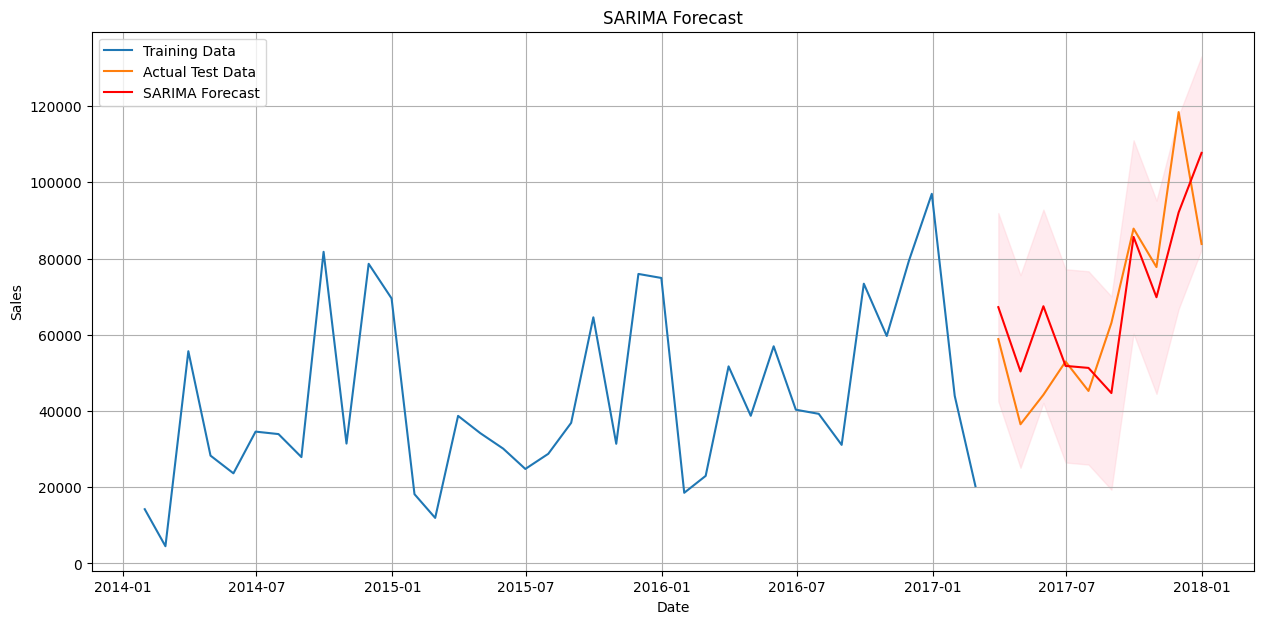

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwkjw4rz9/llia8sp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwkjw4rz9/mql6f9gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97038', 'data', 'file=/tmp/tmpwkjw4rz9/llia8sp8.json', 'init=/tmp/tmpwkjw4rz9/mql6f9gs.json', 'output', 'file=/tmp/tmpwkjw4rz9/prophet_modelkg4pxv8u/prophet_model-20250310172235.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


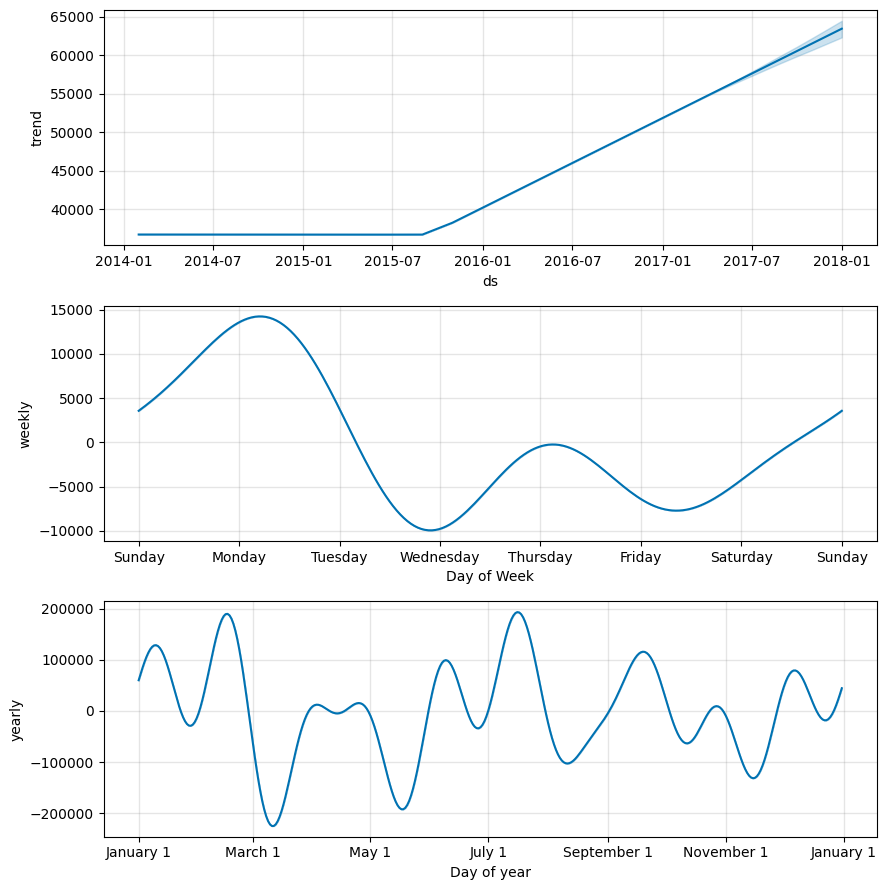

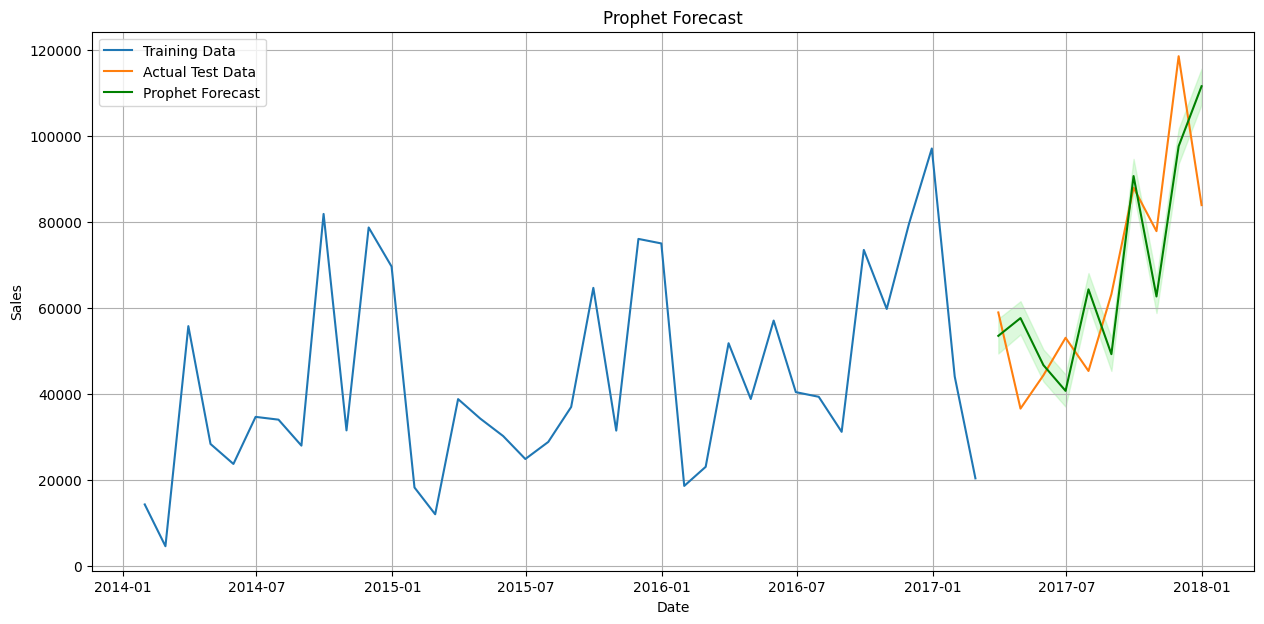

In [ ]:
# Split data into train and test sets
train_size = int(len(monthly_sales) * 0.8)
train_data = monthly_sales.iloc[:train_size]
test_data = monthly_sales.iloc[train_size:]

print(f"Training data: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data: {test_data.index.min()} to {test_data.index.max()}")

# Visualize the split
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['Sales'], label='Training Data')
plt.plot(test_data.index, test_data['Sales'], label='Testing Data', color='orange')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# SARIMA Model
# Based on ACF/PACF, choose appropriate p,d,q,P,D,Q,s parameters
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters

# Fit SARIMA model
sarima_model = SARIMAX(
    train_data['Sales'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Make predictions
sarima_pred = sarima_results.get_forecast(steps=len(test_data))
sarima_mean = sarima_pred.predicted_mean
sarima_ci = sarima_pred.conf_int()

# Plot SARIMA forecasts
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['Sales'], label='Training Data')
plt.plot(test_data.index, test_data['Sales'], label='Actual Test Data')
plt.plot(test_data.index, sarima_mean, label='SARIMA Forecast', color='red')
plt.fill_between(
    test_data.index,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    color='pink',
    alpha=0.3
)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Prophet Model
# Prepare data for Prophet
prophet_train = train_data.reset_index().rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_train)

# Create future dataframe for forecasting
prophet_future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
prophet_forecast = prophet_model.predict(prophet_future)

# Plot Prophet components
prophet_model.plot_components(prophet_forecast)
plt.show()

# Plot Prophet forecast
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['Sales'], label='Training Data')
plt.plot(test_data.index, test_data['Sales'], label='Actual Test Data')
plt.plot(
    pd.to_datetime(prophet_forecast['ds'].iloc[-len(test_data):]),
    prophet_forecast['yhat'].iloc[-len(test_data):],
    label='Prophet Forecast',
    color='green'
)
plt.fill_between(
    pd.to_datetime(prophet_forecast['ds'].iloc[-len(test_data):]),
    prophet_forecast['yhat_lower'].iloc[-len(test_data):],
    prophet_forecast['yhat_upper'].iloc[-len(test_data):],
    color='lightgreen',
    alpha=0.3
)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Model Evaluation:
SARIMA - RMSE: 15846.78, MAE: 13141.30
Prophet - RMSE: 16201.12, MAE: 14057.94

Generating future forecasts with SARIMA model


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


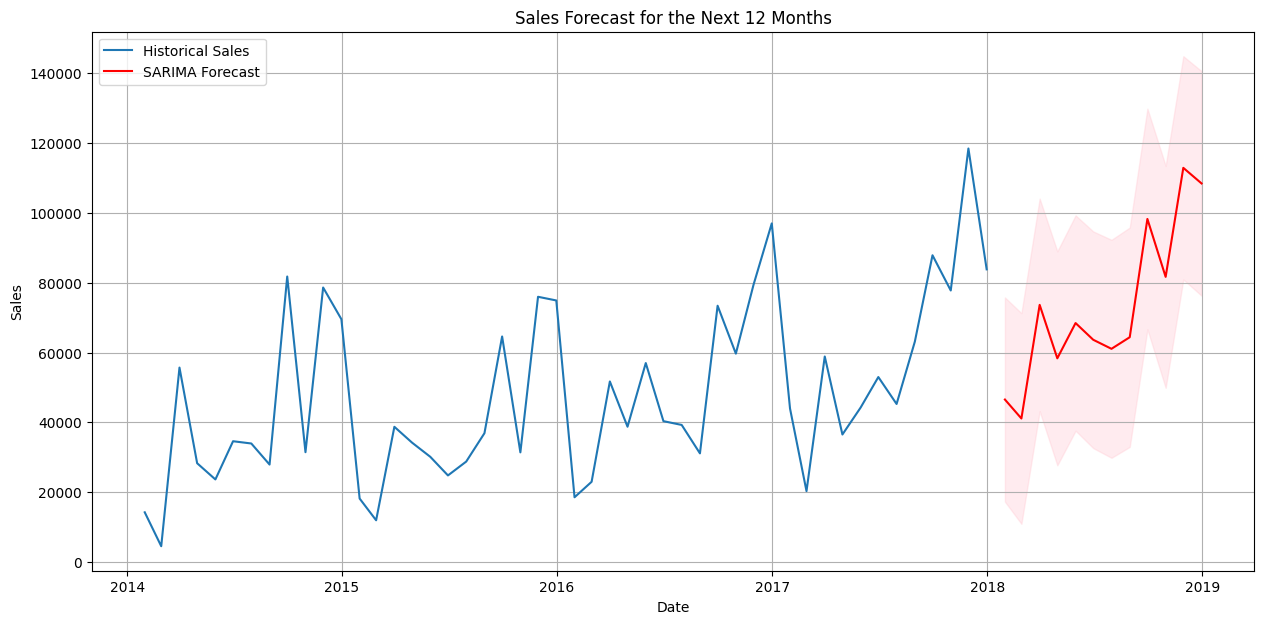

In [ ]:
# Evaluate SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(test_data['Sales'], sarima_mean))
sarima_mae = mean_absolute_error(test_data['Sales'], sarima_mean)

# Evaluate Prophet model
prophet_test_forecast = prophet_forecast.iloc[-len(test_data):]
prophet_rmse = np.sqrt(mean_squared_error(test_data['Sales'].values, prophet_test_forecast['yhat'].values))
prophet_mae = mean_absolute_error(test_data['Sales'].values, prophet_test_forecast['yhat'].values)

# Compare models
print("Model Evaluation:")
print(f"SARIMA - RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")

# Create future predictions (e.g., next 12 months)
# For the better performing model based on evaluation metrics
if sarima_rmse < prophet_rmse:
    print("\nGenerating future forecasts with SARIMA model")
    future_steps = 12

    # Fit model on entire dataset
    full_sarima_model = SARIMAX(
        monthly_sales['Sales'],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    full_sarima_results = full_sarima_model.fit(disp=False)

    # Forecast future periods
    future_sarima_pred = full_sarima_results.get_forecast(steps=future_steps)
    future_sarima_mean = future_sarima_pred.predicted_mean
    future_sarima_ci = future_sarima_pred.conf_int()

    # Create future dates
    last_date = monthly_sales.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='ME')

    # Plot historical data and forecast
    plt.figure(figsize=(15, 7))
    plt.plot(monthly_sales.index, monthly_sales['Sales'], label='Historical Sales')
    plt.plot(future_dates, future_sarima_mean, label='SARIMA Forecast', color='red')
    plt.fill_between(
        future_dates,
        future_sarima_ci.iloc[:, 0],
        future_sarima_ci.iloc[:, 1],
        color='pink',
        alpha=0.3
    )
    plt.title('Sales Forecast for the Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nGenerating future forecasts with Prophet model")
    future_steps = 12

    # Create future dataframe for Prophet
    prophet_full_future = prophet_model.make_future_dataframe(periods=len(test_data) + future_steps, freq='ME')
    prophet_full_forecast = prophet_model.predict(prophet_full_future)

    # Get only the future forecast (beyond historical data)
    prophet_future_forecast = prophet_full_forecast.iloc[-(future_steps):]

    # Plot historical data and forecast
    plt.figure(figsize=(15, 7))
    plt.plot(monthly_sales.index, monthly_sales['Sales'], label='Historical Sales')
    plt.plot(
        pd.to_datetime(prophet_future_forecast['ds']),
        prophet_future_forecast['yhat'],
        label='Prophet Forecast',
        color='green'
    )
    plt.fill_between(
        pd.to_datetime(prophet_future_forecast['ds']),
        prophet_future_forecast['yhat_lower'],
        prophet_future_forecast['yhat_upper'],
        color='lightgreen',
        alpha=0.3
    )
    plt.title('Sales Forecast for the Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()